In [1]:
%matplotlib inline
from utils import *
from pycaret.regression import*

In [2]:
def get_data(dataset_name, file_names_range, target, features, win_size=None, step_size_ratio=1):
    
    dataset_df = pd.DataFrame()        
    for n in file_names_range:        
        file_path = get_dataset_file_path(dataset_name, 'record_'+"{0:0=2d}".format(n)) 
        data = pd.read_pickle( file_path )  
        target_df = data.filter(regex=target, axis=1)
        features_df = data.filter(regex=features, axis=1)

        if win_size is not None:
            data_df = pd.DataFrame()    
            step_size = int(step_size_ratio * win_size)
                
            for i in range(0, len(features_df)- win_size, step_size):
                row = { target: target_df.loc[i+win_size-1, target]}
                
                for feature_name in features_df.columns: 
                    for j in range(win_size):
                        row.update({ feature_name + "{0:0=2d}".format(j): features_df.loc[i+j, feature_name] })
                data_df = data_df.append(row, ignore_index=True)
        else:
            data_df = pd.concat([features_df, target_df], axis=1)
        
        dataset_df = dataset_df.append(data_df, ignore_index=True)
    
    dataset_df = dataset_df.rename({target:'target'}, axis=1)
    return dataset_df

# Data

#### Load Data

In [56]:
dataset_name = 'dataset_02' 
target = 'distance_1' 
features = 'rssi' 
win_size = 20
step_size_ratio = .2

# Tarining
file_names_range = np.arange(5,30)
data = get_data( dataset_name, file_names_range, target, features, win_size=win_size, step_size_ratio=step_size_ratio )

# Test
file_names_range = np.arange(5)
data_unseen = get_data( dataset_name, file_names_range, target, features, win_size=win_size, step_size_ratio=step_size_ratio )

display(data)

,target,rssi_000,rssi_001,rssi_002,rssi_003,rssi_004,rssi_005,rssi_006,rssi_007,rssi_008,...,rssi_110,rssi_111,rssi_112,rssi_113,rssi_114,rssi_115,rssi_116,rssi_117,rssi_118,rssi_119
0,0.388405,142.727273,142.727273,142.727273,142.727273,142.727273,142.727273,142.727273,142.727273,142.727273,...,129.090909,128.727273,128.272727,127.909091,127.727273,127.727273,127.727273,127.727273,127.727273,128.000000
1,0.388317,142.727273,142.727273,142.727273,142.727273,142.727273,142.727273,142.727273,142.636364,142.545455,...,127.727273,127.727273,127.727273,127.727273,127.727273,128.000000,128.272727,128.636364,129.000000,129.545455
2,0.387639,142.727273,142.727273,142.727273,142.636364,142.545455,142.454545,142.363636,142.272727,142.181818,...,127.727273,128.000000,128.272727,128.636364,129.000000,129.545455,130.090909,130.636364,131.181818,131.727273
3,0.385773,142.545455,142.454545,142.363636,142.272727,142.181818,142.090909,142.000000,142.000000,142.000000,...,129.000000,129.545455,130.090909,130.636364,131.181818,131.727273,132.181818,132.727273,133.000000,133.272727
4,0.383950,142.181818,142.090909,142.000000,142.000000,142.000000,142.000000,142.000000,142.090909,142.181818,...,131.181818,131.727273,132.181818,132.727273,133.000000,133.272727,133.545455,133.818182,134.090909,134.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3041,0.458473,88.454545,89.090909,89.727273,90.363636,91.000000,91.272727,91.363636,91.272727,91.090909,...,135.545455,135.454545,135.363636,135.272727,135.181818,135.090909,134.909091,134.818182,134.727273,134.636364
3042,0.458182,91.000000,91.272727,91.363636,91.272727,91.090909,90.818182,90.454545,90.090909,89.636364,...,135.181818,135.090909,134.909091,134.818182,134.727273,134.636364,134.545455,134.363636,134.181818,134.000000
3043,0.457867,91.090909,90.818182,90.454545,90.090909,89.636364,89.181818,88.727273,88.272727,87.909091,...,134.727273,134.636364,134.545455,134.363636,134.181818,134.000000,133.818182,133.636364,133.454545,133.363636
3044,0.457769,89.636364,89.181818,88.727273,88.272727,87.909091,87.636364,87.363636,87.090909,86.818182,...,134.181818,134.000000,133.818182,133.636364,133.454545,133.363636,133.000000,132.636364,132.272727,131.818182


# Regression

In [57]:
exp_reg = setup(data,
                train_size = .95,
                target = 'target', 
                normalize = True, 
                session_id = 20
                )   

 
Setup Succesfully Completed!


,Description,Value
0,session_id,20
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(3046, 41)"
4,Missing Values,False
5,Numeric Features,40
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


#### Model

In [90]:
model = tune_model('xgboost')
# model = create_model('rf')

NRMSE = round(exp_reg[-1][-1][-1].RMSE.Mean / np.mean(data.target) * 100, 2)
print(NRMSE)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0629,0.0071,0.0840,-0.1167,0.0620,0.2163
1,0.0672,0.0075,0.0865,-0.0457,0.0645,0.2359
2,0.0667,0.0081,0.0902,-0.2888,0.0670,0.2473
3,0.0614,0.0059,0.0767,0.2035,0.0582,0.2252
4,0.0620,0.0070,0.0837,-0.0016,0.0622,0.2231
5,0.0627,0.0069,0.0830,-0.1234,0.0617,0.2248
6,0.0687,0.0081,0.0900,-0.0743,0.0667,0.2503
7,0.0589,0.0056,0.0747,0.0127,0.0559,0.2005
8,0.0678,0.0074,0.0857,-0.0923,0.0630,0.2232
9,0.0658,0.0078,0.0881,-0.2197,0.0657,0.2382


25.86


In [93]:
# plot_model(model, plot='error')
# plot_model(model, plot='feature')

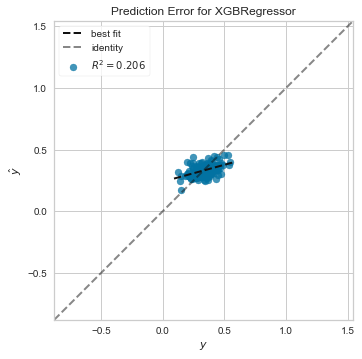

In [105]:
model = tune_model('xgboost')
plot_model(model, plot='error')


#### Test

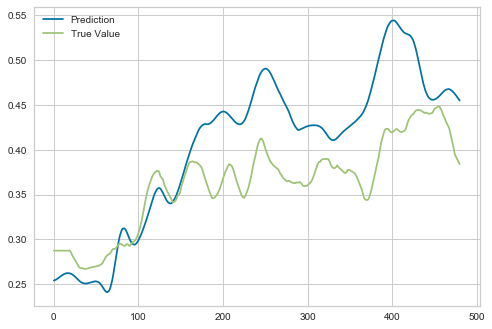

In [103]:
data_unseen = get_data( dataset_name, [10], target, features, win_size=win_size, step_size_ratio=1/20 )
prediction = predict_model(model, data=data_unseen)

window_length = 20
labels = prediction.Label
labels = labels.rolling(window_length, axis=0).mean()    # Smoothing
labels = labels.ffill(axis=0).bfill(axis=0)              # Gap Filling
    
ax = prediction.plot(y='target', legend=False)
labels.plot(y='Label', ax=ax)
plt.legend(['Prediction','True Value'])
# data_unseen.plot(y='rssi_1')
plt.show()


In [ ]:
# save_experiment(get_result_file_path('res_00'))

#### Compare Regressors

In [18]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.056600,0.005100,0.071000,0.234800,0.054000,0.198900
1,AdaBoost Regressor,0.056800,0.005100,0.071200,0.234000,0.054100,0.200300
2,Gradient Boosting Regressor,0.056700,0.005100,0.071200,0.230400,0.054100,0.199000
3,CatBoost Regressor,0.057100,0.005200,0.071800,0.217700,0.054600,0.200800
4,Support Vector Machine,0.057600,0.005200,0.072000,0.217000,0.054600,0.201200
5,Light Gradient Boosting Machine,0.059800,0.005700,0.075600,0.133400,0.057400,0.209900
6,Bayesian Ridge,0.061700,0.005800,0.075900,0.132900,0.057600,0.217700
7,Linear Regression,0.061600,0.005800,0.075900,0.132800,0.057500,0.217600
8,Ridge Regression,0.061600,0.005800,0.075900,0.132800,0.057500,0.217600
9,Least Angle Regression,0.061600,0.005800,0.075900,0.132800,0.057500,0.217600


# sklearn

In [ ]:
from sklearn import*
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [50]:
X_train = data.filter(regex='rssi', axis=1).to_numpy()
Y_train = data.filter(regex='target', axis=1).to_numpy()

model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
model.fit(X_train, Y_train)



Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

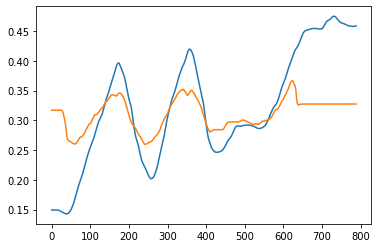

In [55]:
data_unseen = get_data( dataset_name, [29], target, features, win_size=win_size, step_size_ratio=step_size_ratio )

X_validation = data_unseen.filter(regex='rssi', axis=1).to_numpy()
Y_validation = data_unseen.filter(regex='target', axis=1).to_numpy()

predictions = model.predict( X_validation )  

plt.plot(Y_validation)
plt.plot(predictions)
plt.show()